In [21]:
# Task: import libraries and set plotting style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme(style="whitegrid")


In [22]:
# Task: load data from Excel files
df_teaching = pd.read_excel('Teaching staff.xlsx', sheet_name='Data', header=3, na_values=['...', '…'])
df_women_legislators = pd.read_excel('Women legislators and managers.xlsx', sheet_name='Data', header=3, na_values=['...', '…'])
df_legal_age = pd.read_excel('Legal Age for Marriage.xlsx', sheet_name='Data', header=3, na_values=['...', '…'])
df_marriages = pd.read_excel('Marriages.xlsx', sheet_name='Data', header=5, na_values=['...', '…'])
df_part_time = pd.read_excel('Part-time employment.xlsx', sheet_name='Data', header=5, na_values=['...', '…'])


In [23]:
# Task: inspect teaching dataframe structure
df_teaching.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or area  205 non-null    object 
 1   Year             195 non-null    float64
 2   Unnamed: 2       20 non-null     object 
 3   %                195 non-null    float64
 4   Unnamed: 4       0 non-null      float64
 5   Year.1           181 non-null    float64
 6   Unnamed: 6       37 non-null     object 
 7   %.1              181 non-null    float64
 8   Unnamed: 8       0 non-null      float64
 9   Year.2           163 non-null    float64
 10  Unnamed: 10      26 non-null     object 
 11  %.2              163 non-null    float64
dtypes: float64(8), object(4)
memory usage: 19.3+ KB


In [24]:
# Task: drop unused marriage columns
df_marriages = df_marriages.drop('Unnamed: 4', axis=1)
df_marriages = df_marriages.drop('Unnamed: 7', axis=1)


In [25]:
# Task: rename marriage columns for clarity
df_marriages.columns.values[0] = 'Country'
df_marriages.columns.values[2] = 'population women 15-19 ever married (%)'
df_marriages.columns.values[3] = 'population men 15-19 ever married (%)'
df_marriages.columns.values[4] = 'women average single age before marriage (year)'
df_marriages.columns.values[5] = 'men average single age before marriage (year)'
df_marriages.columns.values[6] = 'Source'
df_marriages.head()


,Country,Year,population women 15-19 ever married (%),population men 15-19 ever married (%),women average single age before marriage (year),men average single age before marriage (year),Source
0,Afghanistan,2010,17.3,NaN,21.5,NaN,DHS
1,Albania,2011,7.2,2.0,25.1,29.2,NS
2,Algeria,2002,1.8,0.2,29.5,33.0,PAPFAM
3,American Samoa,2000,21.4,NaN,25.7,NaN,USCB
4,Angola,1970,35.7,7.6,19.4,24.5,USCB


In [26]:
# Task: rename legislators columns for clarity
df_women_legislators.columns.values[0] = 'Country'
df_women_legislators.columns.values[3] = 'Women legislators (%)'
df_women_legislators.columns.values[2] = 'Type'
df_women_legislators.head()


,Country,Year,Type,Women legislators (%),Source
0,Algeria,2004,NaN,4.870624,LFS
1,Anguilla,2001,NaN,52.032520,PC
2,Antigua and Barbuda,2001,NaN,45.059786,PC
3,Argentina,2006,"a,b",23.120202,LFS
4,Armenia,2001,NaN,23.939559,PC


In [27]:
# Task: drop unused legal_age columns
df_legal_age = df_legal_age.drop("With parental consent ", axis=1)
df_legal_age = df_legal_age.drop("Unnamed: 10", axis=1)


In [28]:
# Task: minimal necessary cleaning for df_legal_age
import re

# rename columns (kept as-is)
df_legal_age.columns.values[0] = 'Country'
df_legal_age.columns.values[1] = 'women w/o parental consent minimum age'
df_legal_age.columns.values[2] = 'Type'
df_legal_age.columns.values[3] = 'Men w/o parental consent minimum age'
df_legal_age.columns.values[4] = 'Type'
df_legal_age.columns.values[5] = 'women with parental consent minimum age'
df_legal_age.columns.values[6] = 'Type'
df_legal_age.columns.values[7] = 'Men with parental consent minimum age'
df_legal_age.columns.values[8] = 'Type'
df_legal_age.columns.values[9] = 'Year'

if pd.isna(df_legal_age.iloc[0]['Country']):
    df_legal_age = df_legal_age.drop(0).reset_index(drop=True)

def _to_float(text):
    try:
        return float(text)
    except (TypeError, ValueError):
        return np.nan

# single-value cleaner: '<18' -> 17, '18+' -> 18, '18 years' -> 18, mixed -> first number
def clean_single(age):
    if age is None or (isinstance(age, float) and np.isnan(age)):
        return np.nan
    s = str(age).strip().lower().replace('years', '').strip()
    m = re.search(r'(\d+(?:\.\d+)?)', s)
    num = _to_float(m.group(1)) if m else np.nan
    if s.startswith('<') or s.startswith('<='):
        return num - 1 if not np.isnan(num) else np.nan
    if s.startswith('>') or s.startswith('>=') or s.endswith('+'):
        return num
    return _to_float(s) if re.fullmatch(r'\d+(?:\.\d+)?', s) else num

# range cleaner: '12-18' -> 12, '12 and 18'/'12/18' -> first number, else -> single
def clean_range(age):
    if age is None or (isinstance(age, float) and np.isnan(age)):
        return np.nan
    s = str(age).strip().lower().replace('years', '').strip()
    s = s.replace('–', '-')
    s = s.replace(' to ', '-')
    s = s.replace(' and ', ',')
    s = s.replace('/', ',')
    if '-' in s:
        parts = [p.strip() for p in s.split('-') if p.strip()]
        return _to_float(parts[0]) if parts else np.nan
    if ',' in s:
        parts = [p.strip() for p in s.split(',') if p.strip()]
        return _to_float(parts[0]) if parts else np.nan
    return clean_single(s)

# apply minimal cleaning only to needed columns
df_legal_age['women with parental consent minimum age'] = df_legal_age['women with parental consent minimum age'].apply(clean_single)
df_legal_age['Men with parental consent minimum age'] = df_legal_age['Men with parental consent minimum age'].apply(clean_single)
df_legal_age['women w/o parental consent minimum age'] = df_legal_age['women w/o parental consent minimum age'].apply(clean_range)
df_legal_age['Men w/o parental consent minimum age'] = df_legal_age['Men w/o parental consent minimum age'].apply(clean_range)

# minimal country cleaning: strip digits and whitespace only
df_legal_age['Country'] = df_legal_age['Country'].str.replace(r'\d+', '', regex=True).str.strip()

df_legal_age


,Country,women w/o parental consent minimum age,Type,Men w/o parental consent minimum age,Type,women with parental consent minimum age,Type,Men with parental consent minimum age,Type,Year,Source
0,Afghanistan,16.0,NaN,18.0,NaN,15.0,NaN,NaN,NaN,2011,UNPD
1,Aland Islands,18.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,2011,UNSD
2,Albania,NaN,NaN,NaN,NaN,16.0,NaN,18.0,NaN,2011,UNSD
3,Algeria,19.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,2012,CEDAW (51st session)
4,Andorra,16.0,NaN,16.0,NaN,14.0,NaN,14.0,NaN,2001,CEDAW (25th session)
...,...,...,...,...,...,...,...,...,...,...,...
205,Venezuela,12.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,2011,UNSD
206,Vietnam,18.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,2007,CEDAW (37th session)
207,Yemen,15.0,u,15.0,u,NaN,NaN,NaN,NaN,2002,CEDAW (exceptional session 2002)
208,Zambia,21.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN,2011,CEDAW (49th session)


In [29]:
# Task: clean part-time dataframe columns
df_part_time = df_part_time.drop('Unnamed: 2', axis=1)
df_part_time.columns.values[0] = 'Country'
df_part_time.columns.values[2] = 'Type'
df_part_time.columns.values[3] = 'Female part-time (%)'
df_part_time.columns.values[4] = 'Male part-time (%)'
df_part_time.columns.values[5] = 'Female part-time/Total part-time'


In [30]:
# Task: preview part-time dataframe
df_part_time.head()


,Country,Year,Type,Female part-time (%),Male part-time (%),Female part-time/Total part-time,Source
0,Albania,2001,"a,b,c,d",50.200001,46.099998,39.700001,O
1,Argentina,2011,"e,f,g,h",31.299999,11.900000,64.800003,LFS
2,Armenia,2008,"b,i,j",30.100000,19.000000,56.200001,LFS
3,Aruba,1994,"e,k,j",12.300000,4.000000,71.000000,HS
4,Australia,2011,"l,b,f,m,n",38.500000,13.200000,70.900002,LFS


In [31]:
# Task: rename teaching columns
df_teaching.columns.values[0] = 'Country'
df_teaching.columns.values[3] = 'Female Teachers Primary (%)'
df_teaching.columns.values[7] = 'Female Teachers Secondary (%)'
df_teaching.columns.values[11] = 'Female Teachers Tertiary (%)'


In [32]:
# Task: drop unused teaching columns
df_teaching = df_teaching.drop('Unnamed: 2', axis=1)
df_teaching = df_teaching.drop('Unnamed: 4', axis=1)
df_teaching = df_teaching.drop('Unnamed: 6', axis=1)
df_teaching = df_teaching.drop('Unnamed: 8', axis=1)
df_teaching = df_teaching.drop('Unnamed: 10', axis=1)


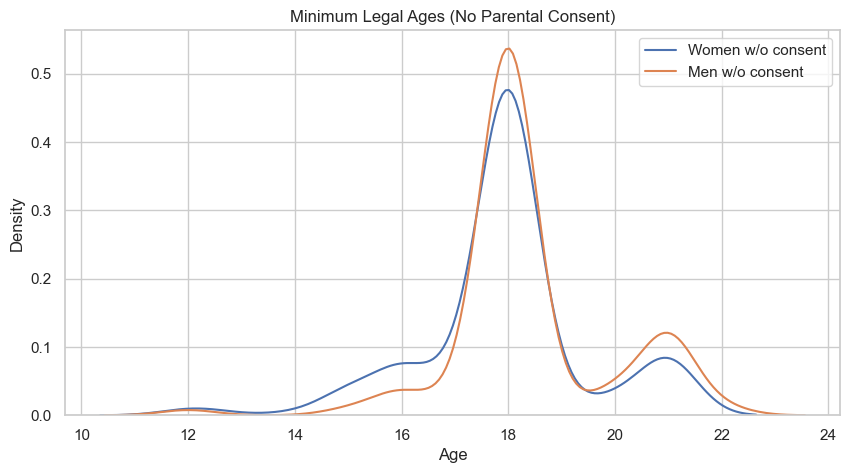

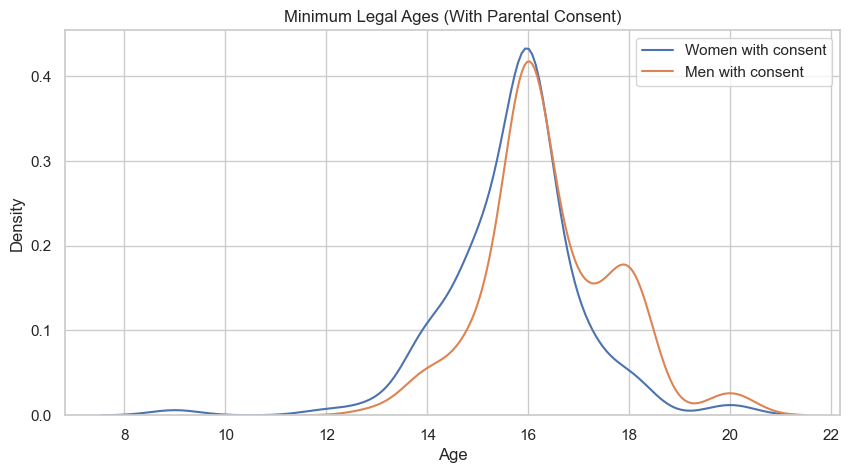

In [33]:
# Task: plot simple KDEs for legal ages
plt.figure(figsize=(10, 5))
women_no = df_legal_age['women w/o parental consent minimum age'].dropna()
men_no = df_legal_age['Men w/o parental consent minimum age'].dropna()
sns.kdeplot(women_no, label='Women w/o consent', fill=False)
sns.kdeplot(men_no, label='Men w/o consent', fill=False)
plt.title('Minimum Legal Ages (No Parental Consent)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
women_yes = df_legal_age['women with parental consent minimum age'].dropna()
men_yes = df_legal_age['Men with parental consent minimum age'].dropna()
sns.kdeplot(women_yes, label='Women with consent', fill=False)
sns.kdeplot(men_yes, label='Men with consent', fill=False)
plt.title('Minimum Legal Ages (With Parental Consent)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()


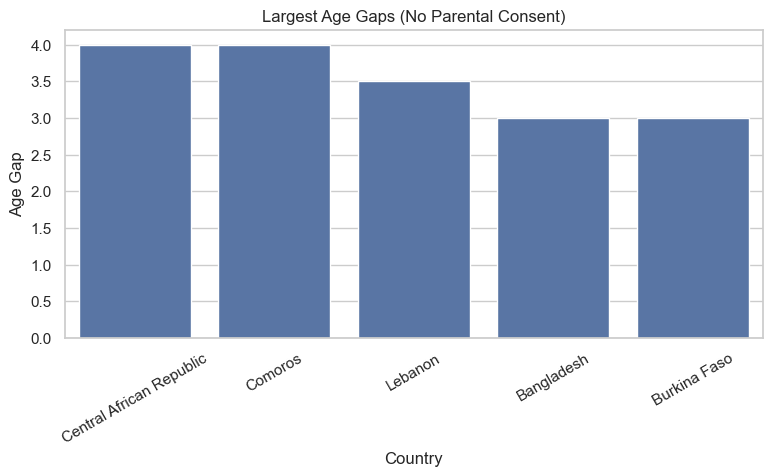

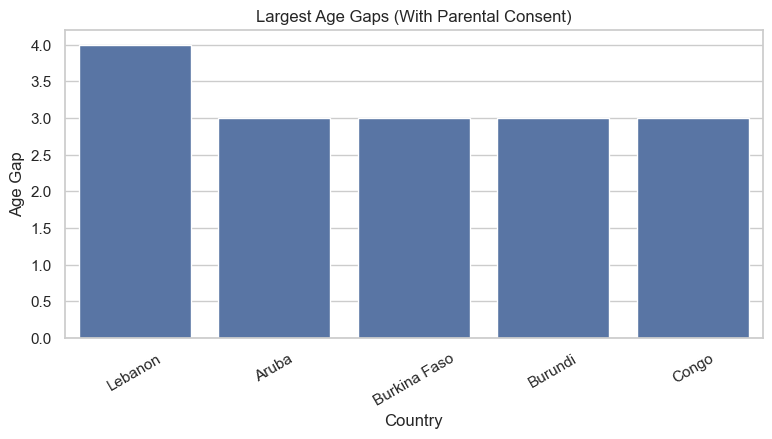

In [34]:
# Task: show simple age gap bar charts
df_legal_age['age_gap_no_consent'] = df_legal_age['Men w/o parental consent minimum age'] - df_legal_age['women w/o parental consent minimum age']
df_legal_age['age_gap_with_consent'] = df_legal_age['Men with parental consent minimum age'] - df_legal_age['women with parental consent minimum age']

top_no = df_legal_age.nlargest(5, 'age_gap_no_consent')
top_yes = df_legal_age.nlargest(5, 'age_gap_with_consent')

plt.figure(figsize=(9, 4))
sns.barplot(data=top_no, x='Country', y='age_gap_no_consent')
plt.title('Largest Age Gaps (No Parental Consent)')
plt.ylabel('Age Gap')
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(9, 4))
sns.barplot(data=top_yes, x='Country', y='age_gap_with_consent')
plt.title('Largest Age Gaps (With Parental Consent)')
plt.ylabel('Age Gap')
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.show()


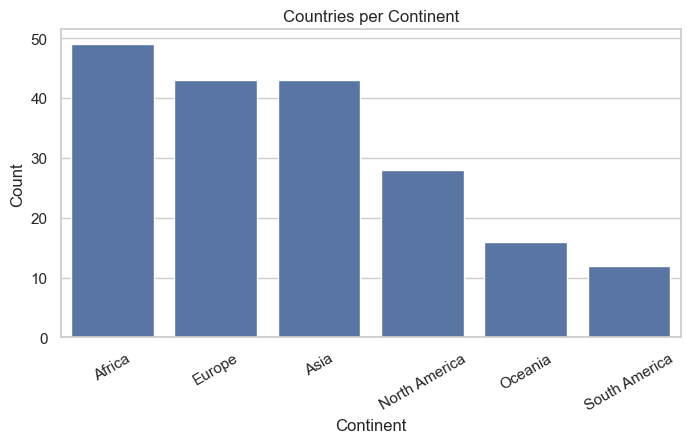

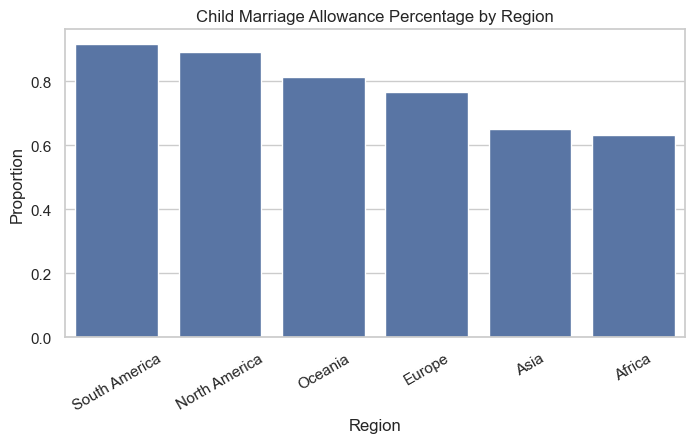

In [35]:
# Task: map countries to continents and plot simple bars
import pycountry_convert as pc
from unidecode import unidecode

def clean_country(name):
    if pd.isna(name):
        return None
    return unidecode(str(name)).strip()

def to_continent(name):
    name = clean_country(name)
    if not name:
        return 'Unknown'
    try:
        alpha2 = pc.country_name_to_country_alpha2(name)
        code = pc.country_alpha2_to_continent_code(alpha2)
        return pc.convert_continent_code_to_continent_name(code)
    except (KeyError, ValueError):
        return 'Unknown'

df_legal_age['Continent'] = df_legal_age['Country'].apply(to_continent)

counts = df_legal_age['Continent'].value_counts()
counts = counts[counts.index != 'Unknown']
plt.figure(figsize=(8, 4))
sns.barplot(x=counts.index, y=counts.values)
plt.title('Countries per Continent')
plt.ylabel('Count')
plt.xlabel('Continent')
plt.xticks(rotation=30)
plt.show()

child = df_legal_age[
    (df_legal_age['women w/o parental consent minimum age'] < 18) |
    (df_legal_age['Men w/o parental consent minimum age'] < 18) |
    (df_legal_age['women with parental consent minimum age'] < 18) |
    (df_legal_age['Men with parental consent minimum age'] < 18)
]
prop = (child.groupby('Continent').size() / df_legal_age.groupby('Continent').size()).drop(labels=['Unknown'], errors='ignore').sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=prop.index, y=prop.values)
plt.title('Child Marriage Allowance Percentage by Region')
plt.ylabel('Proportion')
plt.xlabel('Region')
plt.xticks(rotation=30)
plt.show()


In [36]:
# Task: build simple ISO alpha-3 country codes
import pycountry

def clean_name(name):
    if pd.isna(name):
        return None
    return unidecode(str(name)).strip()

def to_alpha3(name):
    name = clean_name(name)
    if not name:
        return np.nan
    try:
        c = pycountry.countries.lookup(name)
        return c.alpha_3
    except LookupError:
        try:
            c = pycountry.countries.search_fuzzy(name)[0]
            return c.alpha_3
        except (LookupError, IndexError, ValueError):
            return np.nan

df_legal_age['Country_code'] = df_legal_age['Country'].apply(to_alpha3)
df_marriages['Country_code'] = df_marriages['Country'].apply(to_alpha3)


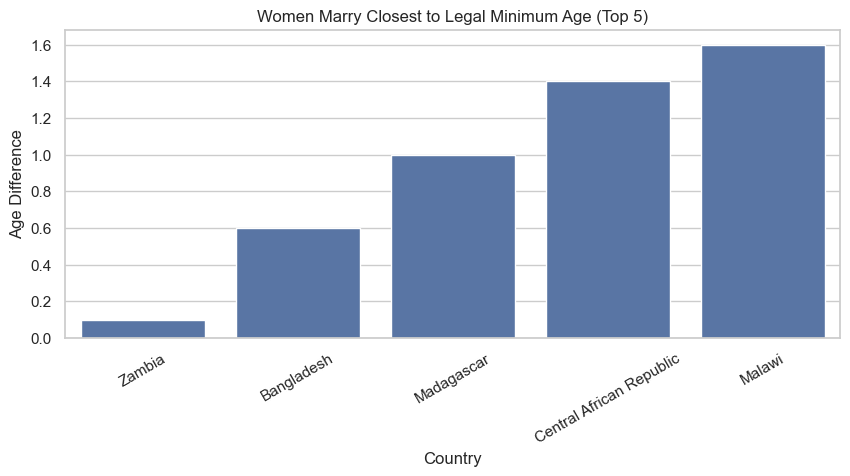

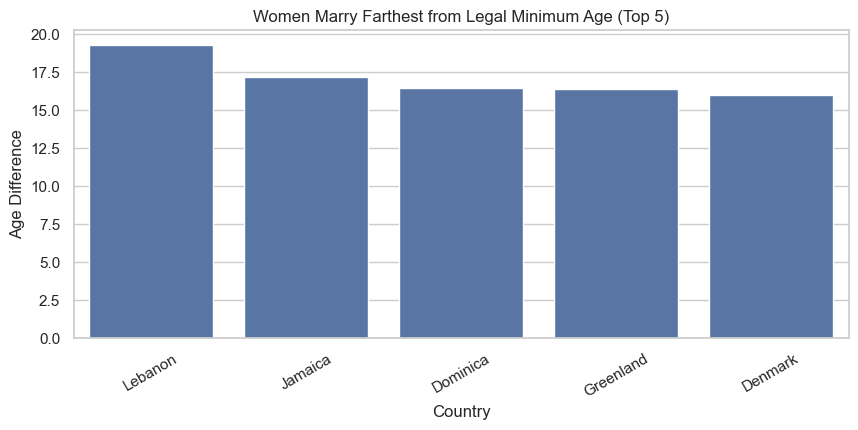

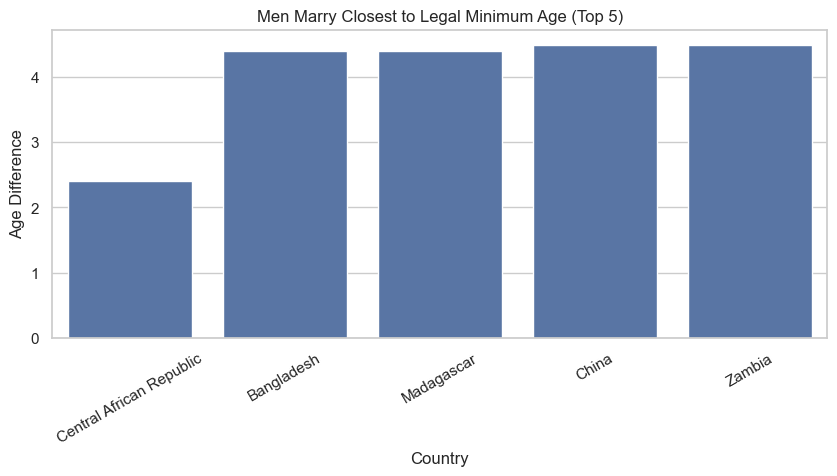

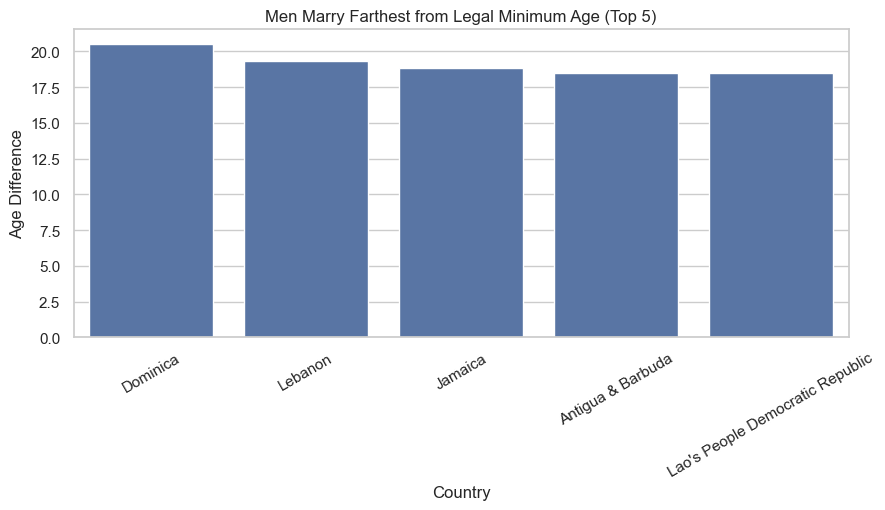

,Country_code,Country,women with parental consent minimum age,Men with parental consent minimum age,women w/o parental consent minimum age,Men w/o parental consent minimum age,women average single age before marriage (year),men average single age before marriage (year),women_consent_age,men_consent_age,women_age_diff,men_age_diff
0,AFG,Afghanistan,15.0,NaN,16.0,18.0,21.5,NaN,15.0,18.0,6.5,NaN
1,ALB,Albania,16.0,18.0,NaN,NaN,25.1,29.2,16.0,18.0,9.1,11.2
2,DZA,Algeria,NaN,NaN,19.0,19.0,29.5,33.0,19.0,19.0,10.5,14.0
3,AGO,Angola,15.0,16.0,18.0,18.0,19.4,24.5,15.0,16.0,4.4,8.5
4,AIA,Anguilla,NaN,NaN,18.0,18.0,28.6,31.6,18.0,18.0,10.6,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...
449,VUT,Vanuatu,15.0,17.0,16.0,18.0,22.6,25.3,15.0,17.0,7.6,8.3
450,VNM,Vietnam,NaN,NaN,18.0,20.0,22.7,26.2,18.0,20.0,4.7,6.2
451,YEM,Yemen,NaN,NaN,15.0,15.0,22.2,25.4,15.0,15.0,7.2,10.4
452,ZMB,Zambia,NaN,NaN,21.0,21.0,21.1,25.5,21.0,21.0,0.1,4.5


In [ ]:
# Task: merge datasets by ISO code and plot simple comparisons
df_legal_clean = df_legal_age[df_legal_age['Country_code'].notna()].copy()
df_marriages_clean = df_marriages[df_marriages['Country_code'].notna()].copy()

merged_df = pd.merge(
    df_legal_clean[['Country_code', 'Country', 'women with parental consent minimum age', 'Men with parental consent minimum age', 'women w/o parental consent minimum age', 'Men w/o parental consent minimum age']],
    df_marriages_clean[['Country_code', 'Country', 'women average single age before marriage (year)', 'men average single age before marriage (year)']],
    on='Country_code', how='inner', suffixes=('_legal','_mar')
)

merged_df = merged_df.rename(columns={'Country_legal': 'Country'})
merged_df = merged_df.drop('Country_mar', axis=1)

merged_df['women_consent_age'] = merged_df['women with parental consent minimum age'].fillna(merged_df['women w/o parental consent minimum age'])
merged_df['men_consent_age'] = merged_df['Men with parental consent minimum age'].fillna(merged_df['Men w/o parental consent minimum age'])

merged_df['women_age_diff'] = merged_df['women average single age before marriage (year)'] - merged_df['women_consent_age']
merged_df['men_age_diff'] = merged_df['men average single age before marriage (year)'] - merged_df['men_consent_age']

closest_women = merged_df.nsmallest(5, 'women_age_diff')
farthest_women = merged_df.nlargest(5, 'women_age_diff')
closest_men = merged_df.nsmallest(5, 'men_age_diff')
farthest_men = merged_df.nlargest(5, 'men_age_diff')

plt.figure(figsize=(10, 4))
sns.barplot(data=closest_women, x='Country', y='women_age_diff')
plt.title('Women Marry Closest to Legal Minimum Age (Top 5)')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=farthest_women, x='Country', y='women_age_diff')
plt.title('Women Marry Farthest from Legal Minimum Age (Top 5)')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=closest_men, x='Country', y='men_age_diff')
plt.title('Men Marry Closest to Legal Minimum Age (Top 5)')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(data=farthest_men, x='Country', y='men_age_diff')
plt.title('Men Marry Farthest from Legal Minimum Age (Top 5)')
plt.ylabel('Age Difference')
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.show()

merged_df
